<a href="https://colab.research.google.com/github/AnkSoni09/Projects/blob/main/IP%20project/IP_Project_Defogging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import cv2
from google.colab.patches import cv2_imshow
from scipy.ndimage.filters import median_filter

In [ ]:
img = cv2.imread("/content/foggy_1.jpg")

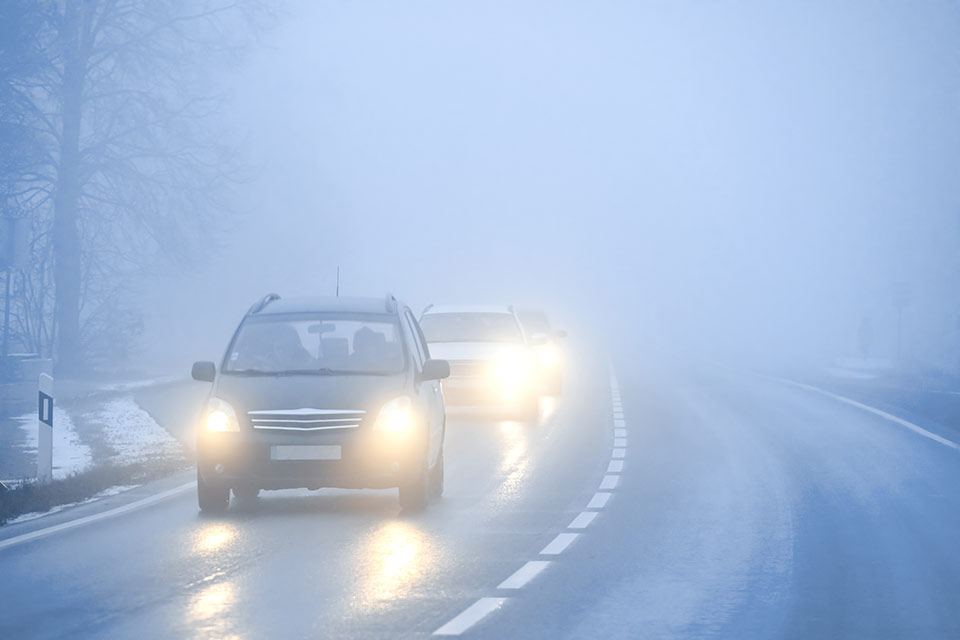

In [ ]:
cv2_imshow(img)

In [ ]:
img.shape

(640, 960, 3)

In [ ]:
def minChannel(img):
  b,g,r = cv2.split(img)
  return cv2.min(cv2.min(r,g),b);

def darkChannel(img,Size = 9):
  window = cv2.getStructuringElement(cv2.MORPH_RECT,(Size,Size))
  dark_channel = cv2.erode(minChannel(img),window)
  return dark_channel

In [ ]:
def get_atmosphere(I, dark, p = 0.001):
  
    M, N = dark.shape
    flatI = I.reshape(M * N, 3)
    flatdark = dark.ravel()
    searchidx = (-flatdark).argsort()[:int(M * N * p)]  # find top M * N * p indexes
    light_region = [(i / N, i % N) for i in searchidx]

    # return the highest intensity for each channel
    return np.max(flatI.take(searchidx, axis=0), axis=0)

In [ ]:
minc = minChannel(img)
drkch = darkChannel(img)
A = get_atmosphere(img,drkch)

In [ ]:
print(A)

[255 255 255]


In [ ]:
# calculating initial transmission
omega = 0.8
t = 1 - omega*np.amin(drkch/min(A))

In [ ]:
# calculating initial t valued image based on DCP
t = max(t,0.1)
I = img.astype(np.float64)
J = np.zeros(I.shape,I.dtype)
for ind in range(0,3):
    J[:,:,ind] = (I[:,:,ind]-A[ind])/t  + A[ind]

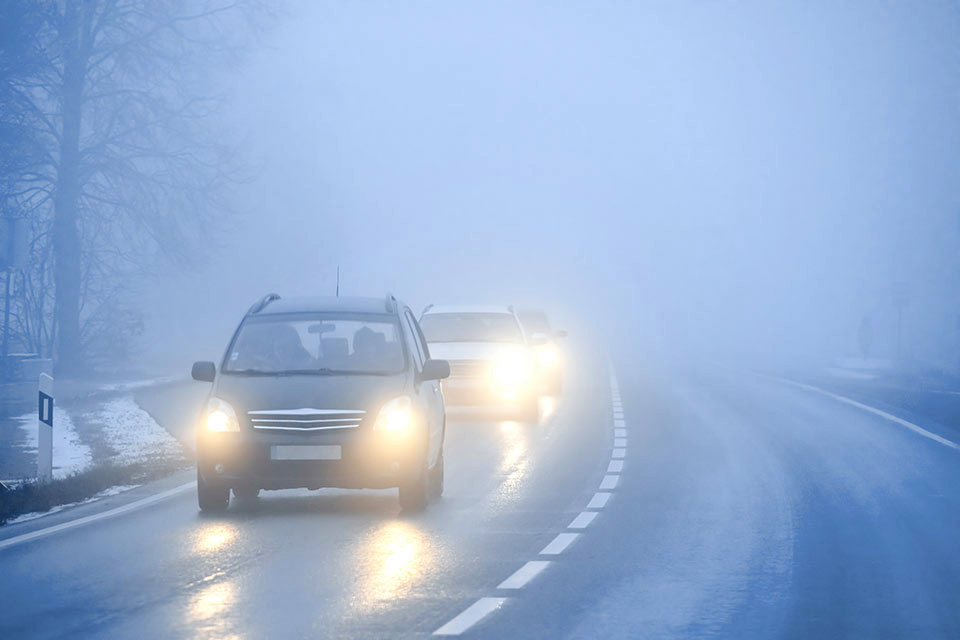

In [ ]:
cv2_imshow(J)

In [ ]:
def Guidedfilter(Image ,p ,r = 10 ,Epsilon = 0.05 ):
    I_mean = cv2.boxFilter(Image,cv2.CV_64F,(r,r));
    p_mean = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    Ip_mean = cv2.boxFilter(Image*p,cv2.CV_64F,(r,r));
    Ip_cov = Ip_mean - I_mean*p_mean;

    II_mean = cv2.boxFilter(Image*Image,cv2.CV_64F,(r,r));
    I_var   = II_mean - I_mean*I_mean;

    a = Ip_cov/(I_var + Epsilon);
    b = p_mean - a*I_mean;

    a_mean = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    b_mean = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = a_mean*Image + b_mean;
    return q, (a_mean, b_mean)

In [ ]:
def FastGuidedfilter(I ,p ,r = 8 ,Epsilon = 0.05, s = 2):


  # downsample
  p_s = cv2.resize(p, dsize=(p.shape[1]//s,p.shape[0]//s), interpolation=cv2.INTER_AREA)
  I_s = cv2.resize(I, dsize=(I.shape[1]//s,I.shape[0]//s), interpolation=cv2.INTER_AREA)
  r_s = int(r / s)


  q_s, ab_mean = Guidedfilter(I_s,p_s , r_s, Epsilon)


  a_mean_s = ab_mean[0]
  b_mean_s = ab_mean[1]

  # upsample
  a_mean = cv2.resize(a_mean_s, dsize=(I.shape[1],I.shape[0]), interpolation=cv2.INTER_CUBIC)
  b_mean = cv2.resize(b_mean_s, dsize=(I.shape[1],I.shape[0]), interpolation=cv2.INTER_CUBIC)

  q = a_mean * I + b_mean

  return q


In [ ]:
# gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# grayJ = cv2.cvtColor(J.astype('uint8'),cv2.COLOR_BGR2GRAY);

In [ ]:
i = FastGuidedfilter(img,J).astype('uint8')

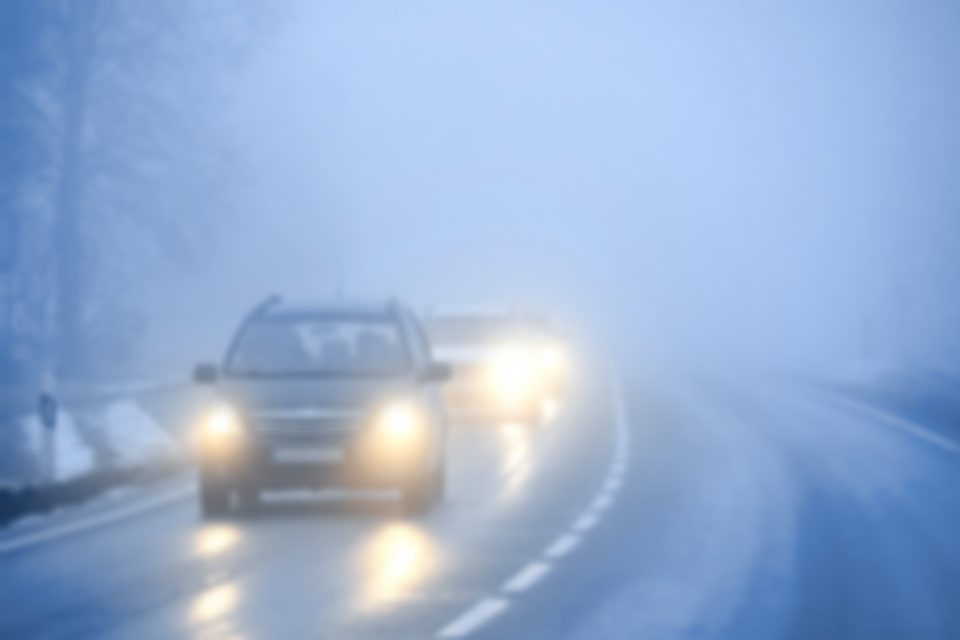

In [ ]:
cv2_imshow(i)

In [ ]:
# dc = median_filter(i,9)

In [ ]:
dc = median_filter(darkChannel(i,9),9)
mnc = minChannel(i)
Am = get_atmosphere(i,dc)

In [ ]:
print(Am)

[255 255 255]


In [ ]:
omega = 0.8
t_m = 1 - omega*median_filter(dc/min(A),9)

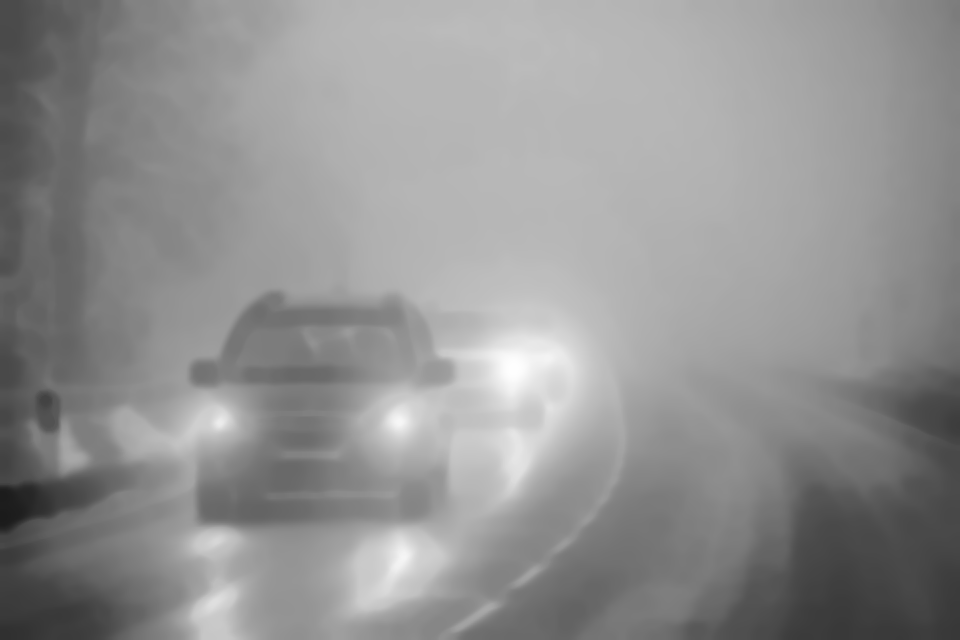

In [ ]:
cv2_imshow(dc)

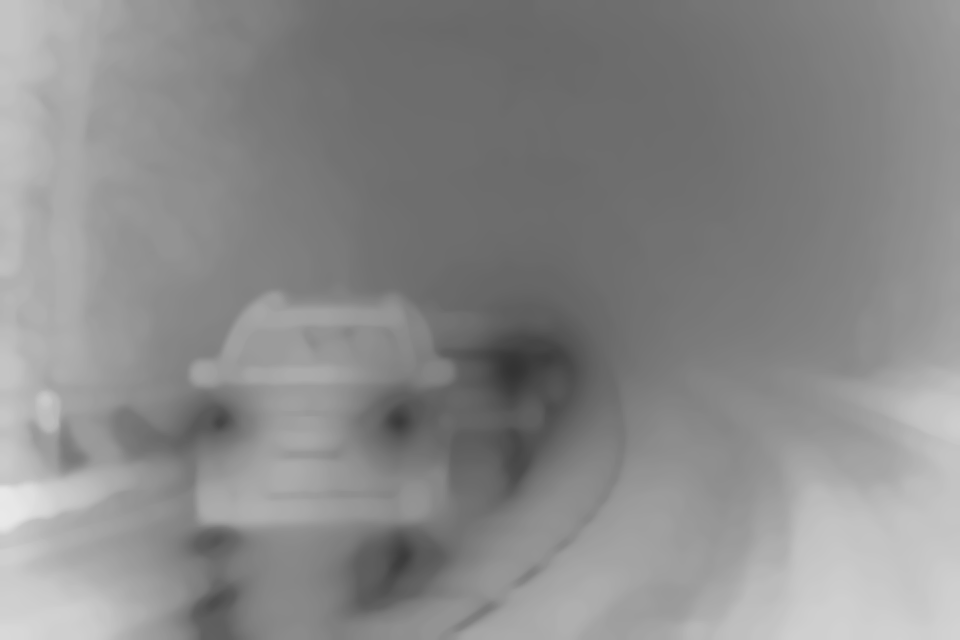

In [ ]:
cv2_imshow(t_m*255)

In [ ]:
t_m = cv2.max(t_m,0.1)
Im = img.astype(np.float64)
Jm = np.zeros(img.shape,img.dtype)
for ind in range(0,3):
    Jm[:,:,ind] = (Im[:,:,ind]-A[ind])/t_m  + A[ind]

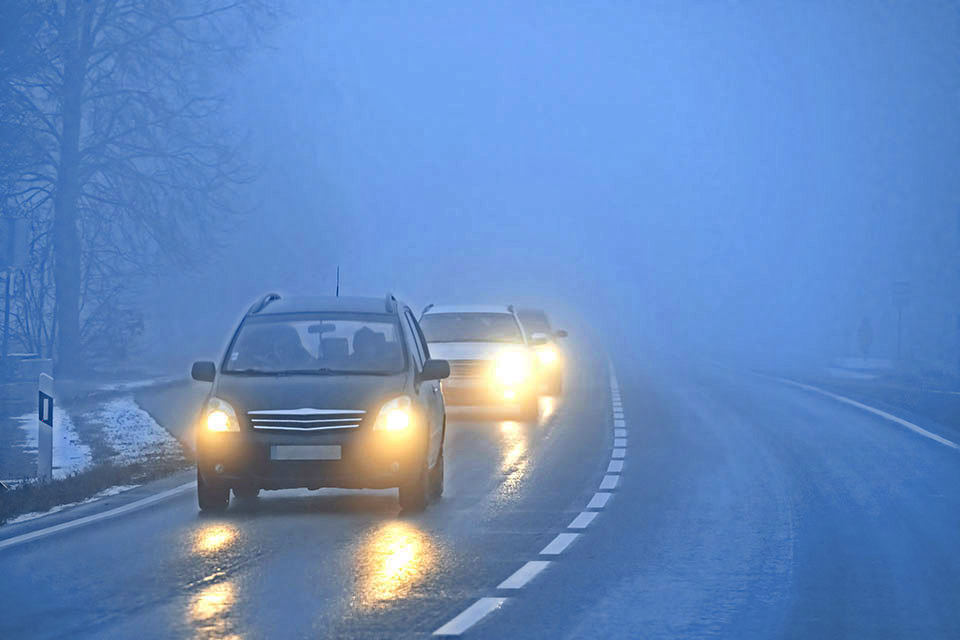

In [ ]:
cv2_imshow(Jm.astype('uint8'))

In [ ]:
def defogg(img):
  # initial t calculation
  minc = minChannel(img)
  drkch = darkChannel(img)
  A = get_atmosphere(img,drkch)

  omega = 0.8
  t = 1 - omega*np.amin(drkch/min(A))
  t = max(t,0.1)
  I = img.astype(np.float64)
  J = np.zeros(I.shape,I.dtype)
  for ind in range(0,3):
      J[:,:,ind] = (I[:,:,ind]-A[ind])/t  + A[ind]

  i = FastGuidedfilter(img,J).astype('uint8')
  dc = median_filter(darkChannel(i),9)
  mnc = minChannel(i)
  Am = get_atmosphere(i,dc)
  t_m = 1 - omega*median_filter(dc/min(A),9)

  t_m = cv2.max(t_m,0.1)
  Im = img.astype(np.float64)
  Jm = np.zeros(img.shape,img.dtype)
  for ind in range(0,3):
      Jm[:,:,ind] = (Im[:,:,ind]-A[ind])/t_m  + A[ind]

  return Jm.astype('uint8')

In [ ]:
im1 = cv2.imread("/content/im1.jpg")

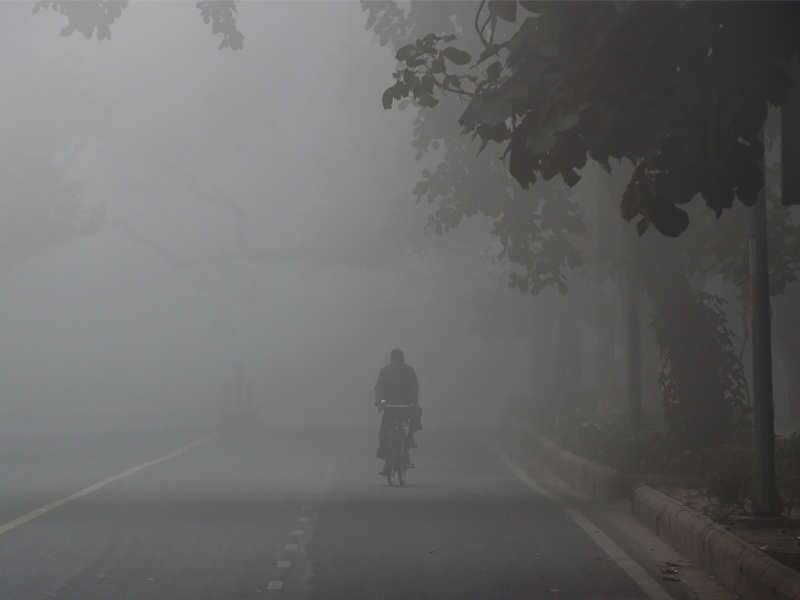

In [ ]:
cv2_imshow(im1)

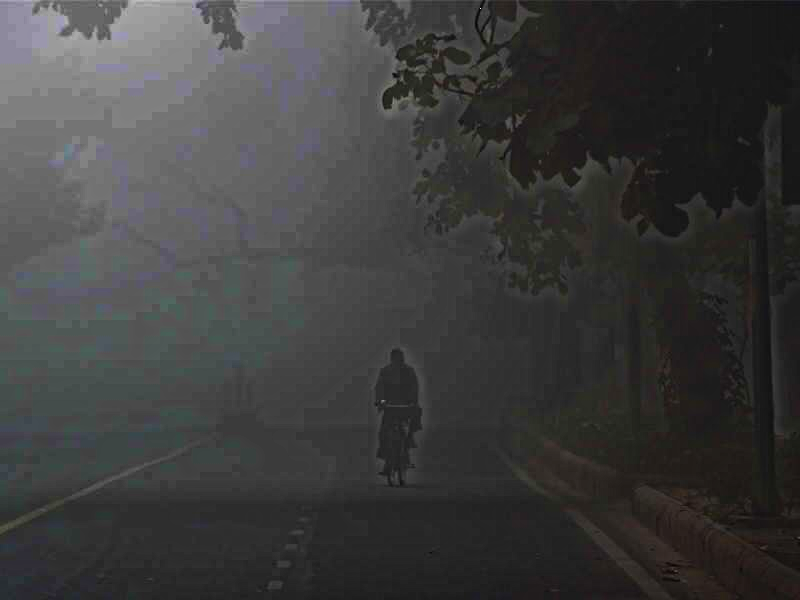

In [ ]:
cv2_imshow(defogg(im1))

In [ ]:
im4 = cv2.imread("/content/im4.jpg")

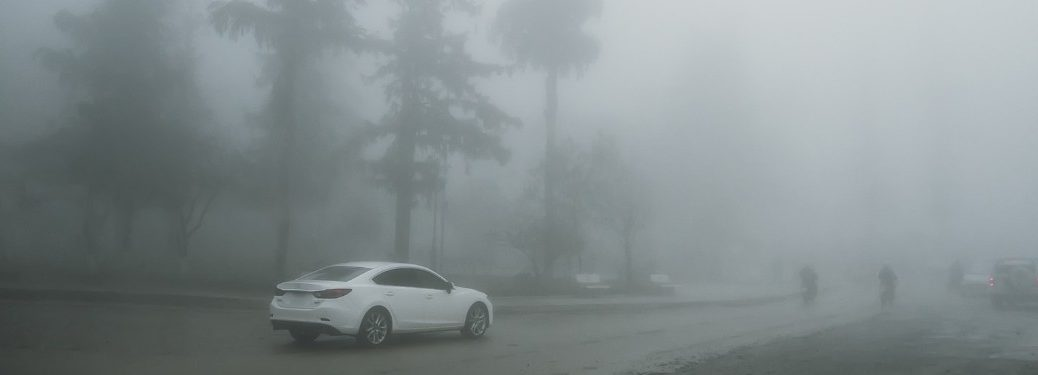

In [ ]:
cv2_imshow(im4)

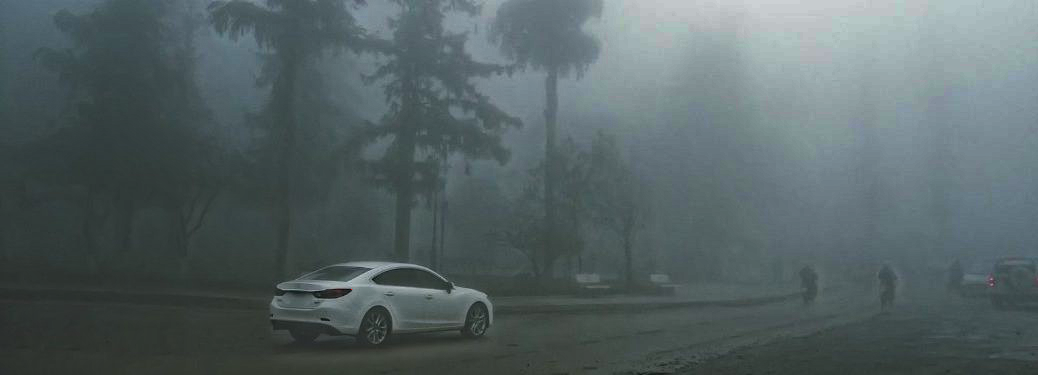

In [ ]:
cv2_imshow(defogg(im4))

In [ ]:
im5 = cv2.imread("/content/im5.png")

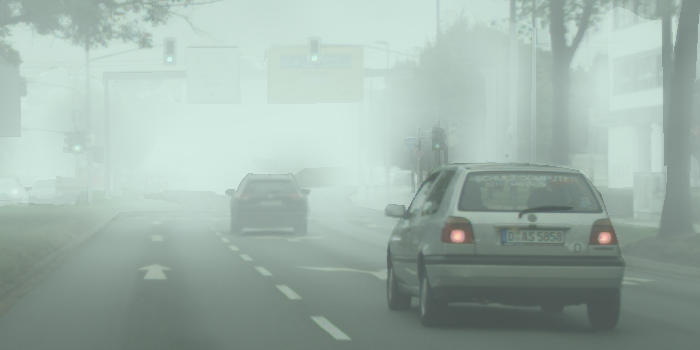

In [ ]:
cv2_imshow(im5)

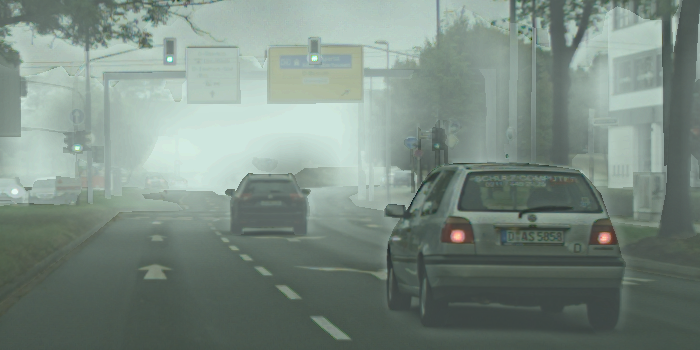

In [ ]:
cv2_imshow(defogg(im5))

In [ ]:
im6 = cv2.imread("/content/im6.webp")

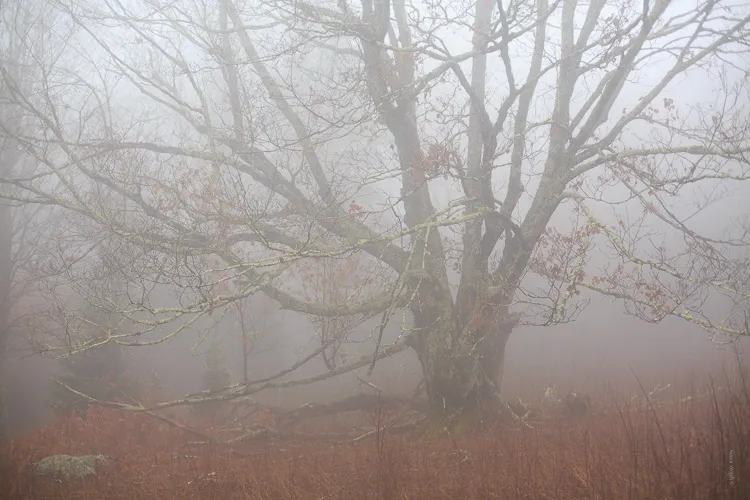

In [ ]:
cv2_imshow(im6)

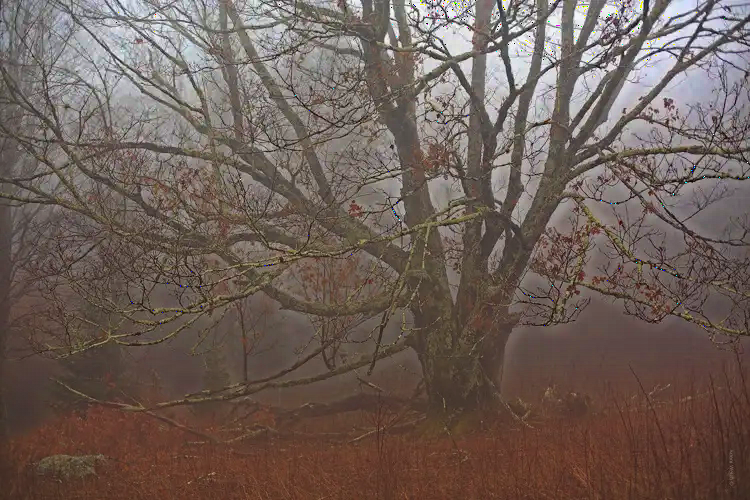

In [ ]:
cv2_imshow(defogg(im6))

In [ ]:
im7 = cv2.imread("/content/im7.jpg")

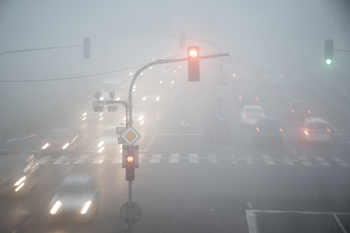

In [ ]:
cv2_imshow(im7)

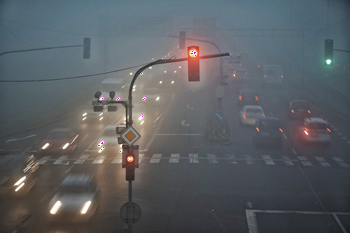

In [ ]:
cv2_imshow(defogg(im7))